INF HW 1 - Young Min Kim

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

(1a) Banknote authentication Data Set from https://archive.ics.uci.edu/ml/datasets/banknote+authentication#

In [6]:
# Dataset file information
filepath = "/Users/ymkim/Desktop/inf552-hw1-workspace/"
num_of_instances = 1372

# Open a file to parse
fo = open(filepath + "data_banknote_authentication.txt", "r")

# init independent var dict (variance, skewness, curtosis, entropy)
vari = {0: [], 1: []}
skew = {0: [], 1: []}
curt = {0: [], 1: []}
entr = {0: [], 1: []}

datalist = [vari, skew, curt, entr]
labellist = ["variance", "skewness", "curtosis", "entropy"]

# contain data from file as a list of tuple ([features], class label)
dataset = []

# parse data and populate into datalist, dataset
n = 0
for line in fo:
    features = line.split(",")
    label = features[len(features) - 1].rstrip('\n')

    row = []
    for i in range(len(features) - 1):
        datalist[i][int(label)].append(float(features[i])) # populate datalist
        row.append(float(features[i]))

    dataset.append((row, int(label))) # populate dataset
    n += 1

fo.close()

(1b) Pre-Processing and Exploratory data anaylsis:

i. Scatterplots

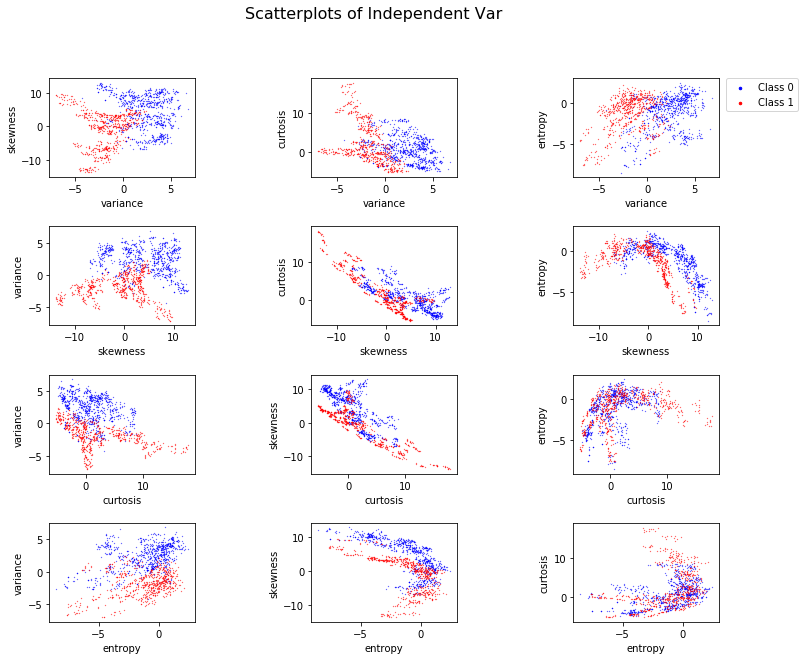

In [7]:
# plot scatter plots for independent var
fig1 = plt.figure(1, figsize=(12,10))
fig1.subplots_adjust(hspace=0.5, wspace=0.8)
fig1.suptitle('Scatterplots of Independent Var', fontsize=16)

nplot = 1
for i in range(len(datalist)):
    for j in range(len(datalist)):
        if i != j:
            # subplot loc
            ax = fig1.add_subplot(4,3,nplot)

            # scatter plot datalist[i] vs. datalist[j]
            # Class 0 is Blue and Class 1 is Red
            s1 = ax.scatter(datalist[i][0], datalist[j][0], s=0.5**2, c="b", marker=".", label="Class 0")
            s2 = ax.scatter(datalist[i][1], datalist[j][1], s=0.5**2, c="r", marker=".", label="Class 1")

            ax.set_ylabel(labellist[j])
            ax.set_xlabel(labellist[i])

            # since all label is same, show legend for a single subplot
            if nplot == 3:
                ax.legend(markerscale=10, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

            nplot += 1

plt.show()

ii. Boxplots

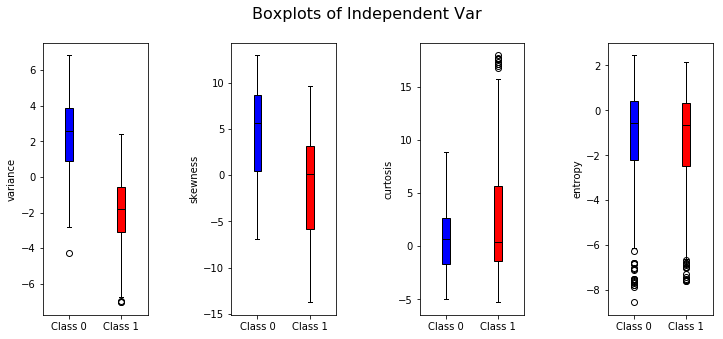

In [8]:
# plot box plots for independent var
fig2 = plt.figure(2, figsize=(12,5))
fig2.subplots_adjust(hspace=0.5, wspace=0.8)
fig2.suptitle('Boxplots of Independent Var', fontsize=16)

for i in range(len(datalist)):
    # subplot loc
    ax = fig2.add_subplot(1,4,i+1)
    ax.set_ylabel(labellist[i]) # set label

    # boxplot for datalist[i]
    bplot = ax.boxplot([datalist[i][0], datalist[i][1]], patch_artist=True, labels=['Class 0', 'Class 1'])

    # fill with colors
    for patch, color in zip(bplot['boxes'], ['blue', 'red']):
        patch.set_facecolor(color)

    plt.setp(bplot['medians'], color='black') # change default median color to black

plt.show()

iii. Select Training and Test dataset

In [182]:
# select training and test data (200 rows of Class 0 and Class 1)
test_size = 200
train_size = num_of_instances - test_size*2

training = {0:[], 1:[]} # training data here!!!
testing = {0:[], 1:[]} # test data here !!!

for t in dataset:
    if len(testing[t[1]]) != test_size:
        testing[t[1]].append(t[0])
    else:
        training[t[1]].append(t[0])

assert(len(testing[0]) + len(testing[1]) == test_size*2), "Incorrect Test Size"
assert(len(training[0]) + len(training[1]) == train_size), "Incorrect Training Size"


training_size = len(training[0]) + len(training[1])
testing_size = len(testing[0]) + len(testing[1])

print("Training Size:", training_size, "Test Size:", testing_size)

Training Size: 972 Test Size: 400


(1c) KNN Classification on Banknote authentication dataset

i. k-nearest neighbor with Euclidean metric

In [183]:
# using scikit-learn python package for KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

trainingdata = training[0] + training[1] # training data
targetvalues = [0]*len(training[0]) + [1]*len(training[1]) # target values

ii. Testing all data in testset

In [184]:
# Euclidean Distance (p = 2)
# Manhattan Distance (p = 1)
def knn_minkowski(x, y, k, p, w='uniform'):
    neigh = KNeighborsClassifier(n_neighbors=k, weights=w, p=p, metric='minkowski')
    neigh.fit(x, y)
    return neigh

# Chebyshev Distance (p = inf)
def knn_chebyshev(x, y, k, w='uniform'):
    neigh = KNeighborsClassifier(n_neighbors=k, weights=w, metric='chebyshev')
    neigh.fit(x, y)
    return neigh

# Mahalanobis Distance
def knn_mahalanobis(x, y, k):
    # using algorithm='auto' default to 'ball_tree' doesnt work according to stackover link below
    # https://stackoverflow.com/questions/34643548/how-to-use-mahalanobis-distance-in-sklearn-distancemetrics
    neigh = KNeighborsClassifier(algorithm='brute', n_neighbors=k, 
                                      metric='mahalanobis', metric_params={'V':np.cov(x)})
    neigh.fit(x, y)
    return neigh
    

# Varying k value from klist to test KNN Classifier (neigh)
# return ktest, kstat map
def ktest_handler(x, y, klist, metric, metric_param, testset):
    ktest = {} # map/dict store k and its following test error
    kstat = {} # map/dict store k and its following statistics (tp, tn, fp, fn, precision, recall, fscore)
    
    # consider Class 0 as Positive Instance (TP if predicted correctly as 0)
    # consider Class 1 as Negative Instance (TN if predicted correctly as 1)
    for k in klist:
        num_of_error = 0
        
        if metric == "chebyshev":
            if "w" in metric_param:
                neigh = knn_chebyshev(x, y, k, w=metric_param["w"])
            else:
                neigh = knn_chebyshev(x, y, k)
        elif metric == "mahalanobis":
            neigh = knn_mahalanobis(x, y, k)
        elif metric == "euclidean":
            if "w" in metric_param:
                neigh = knn_minkowski(x, y, k, 2, w=metric_param["w"])
            else:
                neigh = knn_minkowski(x, y, k, 2)
        else:
            if "w" in metric_param:
                neigh = knn_minkowski(x, y, k, metric_param["p"], w=metric_param["w"])
            else:
                neigh = knn_minkowski(x, y, k, metric_param["p"])
        
        # gather some statistics for confusion matrix
        tp = 0 # true positive - correctly predicted 0
        tn = 0 # true negative - correctly predicted 1
        fp = 0 # false positive - actual 0 but predicted 1
        fn = 0 # false negative - actual 1 but predicted 0

        for label in [0,1]:
            for test in testset[label]:
                predict_label = neigh.predict([test])[0]
                if predict_label != label:
                    num_of_error += 1
                    # incorrectly predicted label
                    if label == 0:
                        fp += 1
                    else:
                        fn += 1
                else:
                    # correctly predicted label
                    if label == 0:
                        tp += 1
                    else:
                        tn += 1

        ktest[k] = num_of_error
        assert(fp+fn == num_of_error), "Error: invalid error count!"

        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        fscore = 2*(precision*recall)/(precision+recall)
        kstat[k] = (tp, tn, fp, fn, precision, recall, fscore)

    return ktest, kstat

# Find the opt k value from ktest map
def find_kstar(ktest):
    min_err_count = num_of_instances
    kstarlist = []
    for k, err in ktest.items():
        if err < min_err_count:
            min_err_count = err
            kstarlist.clear()
            kstarlist.append(k)
        elif err == min_err_count:
            kstarlist.append(k)

    return min_err_count, kstarlist


In [185]:
# run KNN with varying k = {1,4, ... 901}
klist = np.arange(1, 904, 3)

kerr_test, kstat_test = ktest_handler(trainingdata, targetvalues, 
                                      klist, "euclidean", {}, testing) # on test data
kerr_train, kstat_train = ktest_handler(trainingdata, targetvalues, 
                                        klist, "euclidean", {}, training) # on train data

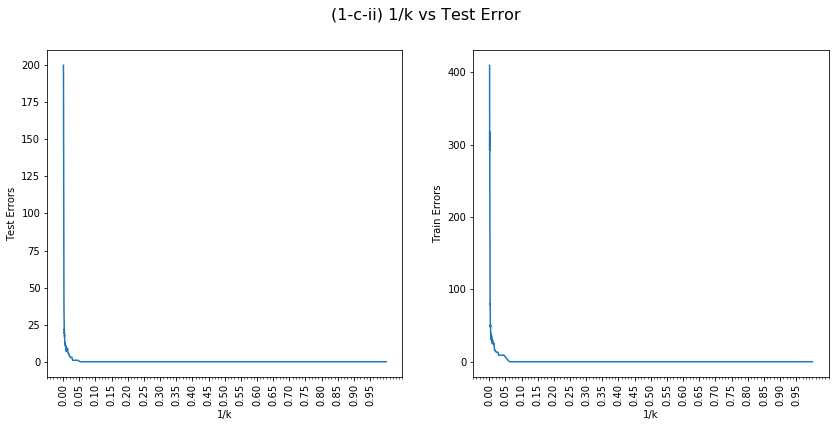

In [483]:
# plot 1/k vs test error
x_inv_k = [1/k for k in list(kerr_test.keys())]
y_err = list(kerr_test.values())

fig3 = plt.figure(3, figsize=(14,6))
fig3.suptitle('(1-c-ii) 1/k vs Test Error', fontsize=16)

ax3_1 = fig3.add_subplot(1,2,1)
ax3_1.plot(x_inv_k, y_err)
ax3_1.set_xlabel('1/k')
ax3_1.set_ylabel('Test Errors')
ax3_1.set_xticks(np.arange(0, 1, 0.05)) # step size = 0.05
minorLocator = MultipleLocator(0.01)
ax3_1.xaxis.set_minor_locator(minorLocator) # show minor tick marks interval of 0.01
plt.xticks(rotation='vertical')

#plot 1/k vs train error
y_err_train = list(kerr_train.values())
ax3_2 = fig3.add_subplot(1,2,2)
ax3_2.plot(x_inv_k, y_err_train)
ax3_2.set_xlabel('1/k')
ax3_2.set_ylabel('Train Errors')
ax3_2.set_xticks(np.arange(0, 1, 0.05)) # step size = 0.05
ax3_2.xaxis.set_minor_locator(minorLocator) # show minor tick marks interval of 0.01

plt.xticks(rotation='vertical')
plt.show()

In [187]:
print('Most Suitable K or *K on [test] data')
min_err_test, kstar_test = find_kstar(kerr_test)
print('\tError Count:', min_err_test, 'K*:', kstar_test)

print('Most Suitable K or *K on [train] data')
min_err_train, kstar_train = find_kstar(kerr_train)
print('\tError Count:', min_err_train, 'K*:', kstar_train)

Most Suitable K or *K on [test] data
	Error Count: 0 K*: [1, 4, 7, 10, 13, 16, 19]
Most Suitable K or *K on [train] data
	Error Count: 0 K*: [1, 4, 7, 10, 13, 16]


(1-c-ii) cont.

The k that have the least error given our training set and test set above is shown above. There are many possible k that gave an error count of 0. Since I do not want to select k value so small that I am fitting to noise, I chose the largest value of k that gave the least error count.

k* from test data = 19

k* from train data = 16

In [188]:
ks_test, ks_train = 19, 16

def print_stat(ks, kerr, kstat, dataset):
    print("test error:", kerr[ks])
    print("tp rate:", kstat[ks][0]/len(dataset[0]))
    print("tn rate:", kstat[ks][1]/len(dataset[1]))
    print("precision:", kstat[ks][4])
    print("fscore:", kstat[ks][6])
    print("-- confusion maxtrix --")
    print('tp:', kstat[ks][0], 'fp:', kstat[ks][2])
    print('fn:', kstat[ks][3], 'tn:', kstat[ks][1])
    print()
    
print("-- k* = 19 for test data --")
print_stat(ks_test, kerr_test, kstat_test, testing)
print("-- k* = 16 for train data --")
print_stat(ks_train, kerr_train, kstat_train, training)


-- k* = 19 for test data --
test error: 0
tp rate: 1.0
tn rate: 1.0
precision: 1.0
fscore: 1.0
-- confusion maxtrix --
tp: 200 fp: 0
fn: 0 tn: 200

-- k* = 16 for train data --
test error: 0
tp rate: 1.0
tn rate: 1.0
precision: 1.0
fscore: 1.0
-- confusion maxtrix --
tp: 562 fp: 0
fn: 0 tn: 410



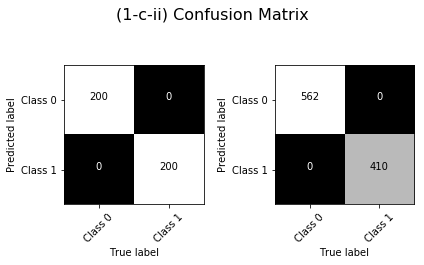

In [484]:
# confusion matrix for error on test data
confmatrix_test = [[kstat_test[ks_test][0], kstat_test[ks_test][2]],
              [kstat_test[ks_test][3], kstat_test[ks_test][1]]]
# confusion matrix for error on train data
confmatrix_train = [[kstat_train[ks_train][0], kstat_train[ks_train][2]],
              [kstat_train[ks_train][3], kstat_train[ks_train][1]]]
conflabels = ['Class 0', 'Class 1']

# show Confusion matrix
fig4 = plt.figure(4)
fig4.suptitle('(1-c-ii) Confusion Matrix', fontsize=16)

ax4_1 = fig4.add_subplot(1,2,1)
ax4_1.imshow(confmatrix_test, cmap=plt.cm.gray)
tick_marks = np.arange(len(conflabels))
for i in range(2):
    for j in range(2):
        ax4_1.text(j, i, format(confmatrix_test[j][i], 'd'), horizontalalignment="center", 
                 color="white" if bool(j) + bool(i) == 1 else "black")
        
plt.xticks(tick_marks, conflabels, rotation=45)
plt.yticks(tick_marks, conflabels)
plt.xlabel('True label')
plt.ylabel('Predicted label')

ax4_2 = fig4.add_subplot(1,2,2)
ax4_2.imshow(confmatrix_train, cmap=plt.cm.gray)
for i in range(2):
    for j in range(2):
        ax4_2.text(j, i, format(confmatrix_train[j][i], 'd'), horizontalalignment="center", 
                 color="white" if bool(j) + bool(i) == 1 else "black")
        
plt.xticks(tick_marks, conflabels, rotation=45)
plt.yticks(tick_marks, conflabels)
plt.xlabel('True label')
plt.ylabel('Predicted label')

fig4.tight_layout()
plt.show()

iii. Plot Learning Curve (best error rate)

In [190]:
# split the training data
def split_trainingdata(n, data):
    upper0 = int(n/2)
    upper1 = int(n/2)
    if len(data[0]) > len(data[1]) and upper1 > len(data[1]):
        upper0 += upper1 - len(data[1]) # add remaining to upper0
        upper1 = len(data[1])
    elif len(data[1]) > len(data[0]) and upper0 > len(data[1]):
        upper1 += upper0 - len(data[0])
        upper0 = len(data[0])
        
    return {0:data[0][:upper0], 1:data[1][:upper1]}

# Varying size of training data N and getting the best error rate 
best_err_rate = {}
new_training_size = np.arange(50, 950, 50)
for n in new_training_size:
    new_training = split_trainingdata(n, training)
    new_klist = np.arange(1,n,40)
    
    new_x = new_training[0] + new_training[1] # training data
    new_y = [0]*len(new_training[0]) + [1]*len(new_training[1]) # target values
    
    assert(len(new_x) == len(new_y) == n), "Error in new training size!!!"
    
    ktest, kstat = ktest_handler(new_x, new_y, new_klist, "euclidean", {}, testing)
    min_err, kstar = find_kstar(ktest)
    best_err_rate[n] = (min_err, kstar)
    

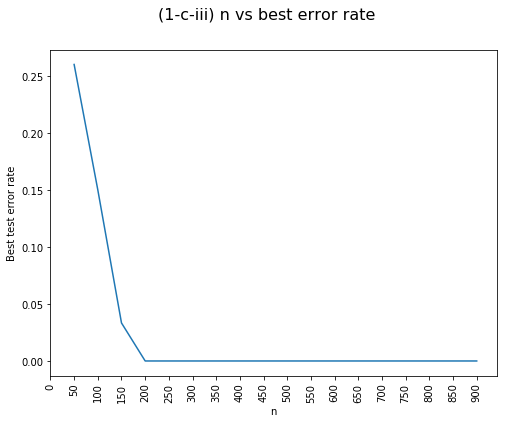

In [485]:
# plot n vs best test error rate
y_err_rate = [v[0]/k for k, v in list(best_err_rate.items())]
x_n = new_training_size

fig5 = plt.figure(5, figsize=(8,6))
fig5.suptitle('(1-c-iii) n vs best error rate', fontsize=16)
ax5 = fig5.add_subplot(1,1,1)
ax5.plot(x_n, y_err_rate)
ax5.set_xlabel('n')
ax5.set_ylabel('Best test error rate')
ax5.set_xticks(np.arange(0, 950, 50))

plt.xticks(rotation='vertical')
plt.show()


(1d) Replace Euclidean metric

i. Minkowski Distance

In [486]:
# run KNN with varying k = {1,11,21 ... 901} for p metric = 1 (Manhanttan Distance)
manh_klist = np.arange(1, 911, 10)
manh_kerr, manh_kstat = ktest_handler(trainingdata, targetvalues, man_klist, 
                                    "minkowski", {"p": 1}, testing)

print('-- Part (1-d-i) A. Manhattan Distance --')
manh_min_err, manh_kstar = find_kstar(man_kerr)
print('Error Count:', manh_min_err, 'K*:', manh_kstar)
print('Best k:', manh_kstar[-1])

-- Part (1-d-i) A. Manhattan Distance --
Error Count: 0 K*: [1, 11]
Best k: 11


In [487]:
# run KNN w/ k=k* and varying log10(p) = {0.1,0.2 ... 1}
print('-- Part (1-d-i) B. Varying p-metric at fixed K* = 11')
fixed_kstar = 11
plist = [10**i for i in np.arange(0.1, 1.1, 0.1)]
for p in plist:
    # train KNN on 'traingdata, targetvalues' w/ fixed_kstar at p = 1 and test on 'testing' data
    p_kerr, p_kstat = ktest_handler(trainingdata, targetvalues, [fixed_kstar], 
                                    "minkowski", {"p": p}, testing)
    print('log10(p):', round(np.log10(p),1), 'num err:', p_kerr)


-- Part (1-d-i) B. Varying p-metric at fixed K* = 11
log10(p): 0.1 num err: {11: 0}
log10(p): 0.2 num err: {11: 0}
log10(p): 0.3 num err: {11: 0}
log10(p): 0.4 num err: {11: 0}
log10(p): 0.5 num err: {11: 0}
log10(p): 0.6 num err: {11: 0}
log10(p): 0.7 num err: {11: 0}
log10(p): 0.8 num err: {11: 0}
log10(p): 0.9 num err: {11: 0}
log10(p): 1.0 num err: {11: 0}


(1-d-i) Part B cont.

From the results above, the best log10(p) can be selected from any one of the above. All results in an error of 0.

In [488]:
# run KNN with varying k = {1,11,21 ... 901} for p metric = inf (Chebyshev Distance)
cheb_klist = np.arange(1, 911, 10)

print('-- Part (1-d-i) C. Chebyshev Distance --')
cheb_kerr, cheb_kstat = ktest_handler(trainingdata, targetvalues, cheb_klist, 
                                    "chebyshev", {}, testing)

cheb_min_err, cheb_kstar = find_kstar(cheb_kerr)
print('Error Count:', cheb_min_err, 'K*:', cheb_kstar)
print('Best k:', cheb_kstar[-1])

-- Part (1-d-i) C. Chebyshev Distance --
Error Count: 0 K*: [1, 11]
Best k: 11


ii. Mahalanobis Distance

In [490]:
# run KNN with varying k = {1,11,21 ... 901} for Mahalanobis Distance
# using algorithm='auto' default to 'ball_tree' doesnt work according to stackover link below
# https://stackoverflow.com/questions/34643548/how-to-use-mahalanobis-distance-in-sklearn-distancemetrics

print('-- (1-d-ii) Mahalanobis Distance --')
maha_klist = np.arange(1, 911, 10)
maha_kerr, maha_kstat = ktest_handler(trainingdata, targetvalues, maha_klist, 
                                    "mahalanobis", {}, testing)

maha_min_err, maha_kstar = find_kstar(maha_kerr)
print('Error Count:', maha_man_err, 'K*:', maha_kstar)

-- (1-d-ii) Mahalanobis Distance --
Error Count: 0 K*: [1, 11]


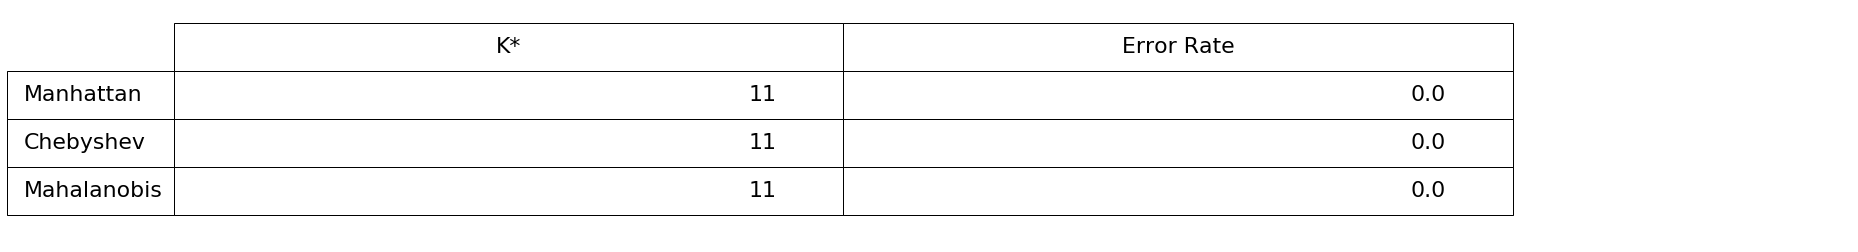

In [480]:
# k* Manhattan Distance
# k* Chebyshev Distance
# k* Mahalanobis Distance

table_data = [[manh_kstar[-1], manh_min_err/testing_size],
              [cheb_kstar[-1], cheb_min_err/testing_size],
              [maha_kstar[-1], maha_min_err/testing_size]]

columns = ('K*', 'Error Rate')
rows = ('Manhattan', 'Chebyshev', 'Mahalanobis')

the_table = plt.table(cellText=table_data,
                      rowLabels=rows,
                      colLabels=columns, loc="left")

the_table.set_fontsize(22)
the_table.scale(4, 4)
plt.axis('tight')
plt.axis('off')

plt.show()

(1e) Replace polling decision to weighted decision (weights = distance)

In [198]:
# run KNN with varying k = {1,11,21 ... 901} for weights = distance
weighted_klist = np.arange(1, 911, 10)

# Euclidean weighted polling
weighted_eucl_kerr, weighted_eucl_kstat = ktest_handler(trainingdata, targetvalues, weighted_klist,
                                                       "euclidean", {"w":'distance'}, testing)
weighted_eucl_min_err, weighted_eucl_kstar = find_kstar(maha_kerr)
print('Euclidean Weighted -> Error Count:', weighted_eucl_min_err, 'K*:', weighted_eucl_kstar)

# Manhattan weighted polling
weighted_manh_kerr, weighted_manh_kstat = ktest_handler(trainingdata, targetvalues, weighted_klist, 
                                    "minkowski", {"p": 1, "w":'distance'}, testing)
weighted_manh_min_err, weighted_manh_kstar = find_kstar(maha_kerr)
print('Manhattan Weighted -> Error Count:', weighted_manh_min_err, 'K*:', weighted_manh_kstar)

# Chebyshev weighted polling
weightedcheb_kerr, weighted_cheb_kstat = ktest_handler(trainingdata, targetvalues, weighted_klist, 
                                    "chebyshev", {"w":'distance'}, testing)
weighted_cheb_min_err, weighted_cheb_kstar = find_kstar(cheb_kerr)
print('Chebyshev Weighted -> Error Count:', weighted_cheb_min_err, 'K*:', weighted_cheb_kstar)

Euclidean Weighted -> Error Count: 0 K*: [1, 11]
Manhattan Weighted -> Error Count: 0 K*: [1, 11]
Chebyshev Weighted -> Error Count: 0 K*: [1, 11]


(1e) cont.

Best k* for weighed Euclidean, Manhattan, and Chebyshev is 11 with an error count of 0.

(1f) Lowest training error rate achieved:

0

(2a) Combined Cycle Power Plant Data Set from https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

(2b) Exploring data:

In [247]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import stats
from regressors import stats as rg
from prettytable import PrettyTable

In [224]:
filepath_2 = "/Users/ymkim/Desktop/inf552-hw1-workspace/CCPP/"
filename = "Folds5x2_pp.xlsx"

df = pd.read_excel(filepath_2 + filename, sheet_name="Sheet1")

# features - independent var
at_list = df['AT'].tolist() # ambient temperature
v_list = df['V'].tolist() # exhaust vaccum
ap_list = df['AP'].tolist() # ambient pressure
rh_list = df['RH'].tolist() # relative humidity

# ouput - dependent var
pe_list = df['PE'].tolist() # electrical energy output

assert(len(at_list) == len(v_list) == len(ap_list) ==
       len(rh_list) == len(pe_list)), "Error: building feature list"

In [226]:
# 2 - b - i
num_rows = len(df) + 1
num_instances = num_rows - 1
num_cols = len(df.columns)
      
print("Num of Rows:", num_rows)
print("Num of Cols:", num_cols)

Num of Rows: 9569
Num of Cols: 5


(2b) sec i.

There are total of 9,569 rows, more specifically 9,568 rows that represent instances and 1 row dedicated to represent the label for each column.

There are total of 5 columns, where 4 of the 5 columns represents the features and the last column represents the output/label.

The rows represent the data or instances (feature vector), whereas the columns represent the features (independent variables).

(2b) sec ii.

Scatterplot of independent var and dependent var. (below)

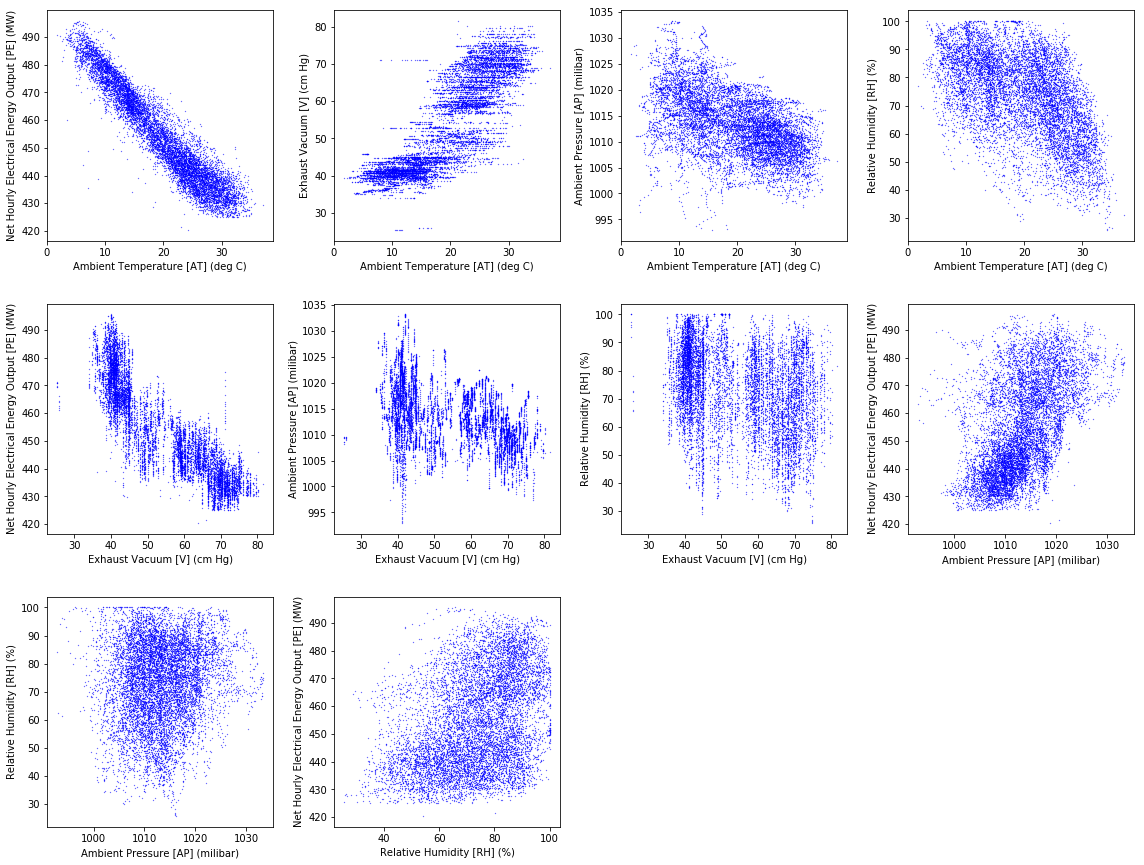

In [504]:
featurelist = [at_list, v_list, ap_list, rh_list]
labellist = ['Ambient Temperature [AT] (deg C)', 'Exhaust Vacuum [V] (cm Hg)',
             'Ambient Pressure [AP] (milibar)', 'Relative Humidity [RH] (%)']

nplot = 1
fig10 = plt.figure(10, figsize=(16,16))
for i in range(len(featurelist)):
    ax = fig10.add_subplot(4,4,nplot)
    sp = ax.scatter(featurelist[i], pe_list, s=0.5**2, c='b', marker='.')

    ax.set_xlabel(labellist[i])
    ax.set_ylabel('Net Hourly Electrical Energy Output [PE] (MW)')
    nplot += 1
    
    for j in range(i+1, len(featurelist)):
        ax = fig10.add_subplot(4,4,nplot)
        sp = ax.scatter(featurelist[i], featurelist[j], s=0.5**2, c='b', marker='.')

        ax.set_xlabel(labellist[i])
        ax.set_ylabel(labellist[j])
        nplot += 1

fig10.tight_layout()
plt.show()

(2b) sec ii. cont.

The general trends we see from the scatter plot above are:

Independent Variables (AT, V, AP, RH) and fixing Dependent Variable as EP:

1. AT vs EP - There is a strong linear relationship between the variables. Having a high ambient temperature results lower net hourly electrical energy output and vice-versa.

2. V vs EP - There is somewhat linear relationship between Vaccum and Energy Output. The general trend is that lower exhaust vacuum results in a high energy output and vice-versa.

3. AP vs EP - The general trend is higher the ambient pressure, higher the net energy output. However, once the net energy output exceeds 450 MW, the linear trend is no longer applicable. 

4. RH vs EP - The general trend is higher the relative humidity, higher the net energy output because it has a larger range of values that net energy output have. 

Other pairwise variables:

1. AT vs V - There is a postive linear relationship between these two variables, higher the ambient temperature, higher the exhaust vacuum.

2. AT vs AP - Even though there are some outliers in this plot, the general linear trend is that lower, the ambient temperature, higher the ambient pressure and vice-versa.

3. AT vs RH - The general trend is that high ambient temperature results in relatively low humidity.

4. V vs AP - The trend somewhat matches sine wave.

5. V vs RH - Higher the exhaust vacuum, the larger the range of values that relative humidity can take.

6. AP vs RH - Much of the data is concentrated between 1005 and 1020 milibar where relative humidity can a wide range of values. 

(2b) sec iii. 

Summary Table of mean, media, range, first and third quartiles, and interquartile ranges shown below

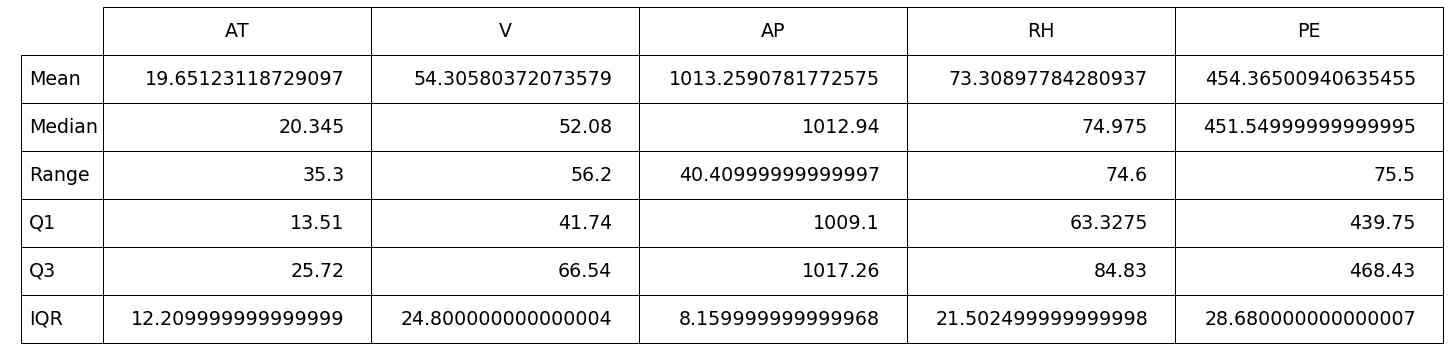

In [505]:
# 2 - b - iii
datalist = [at_list, v_list, ap_list, rh_list, pe_list]
np_datalist = np.array(datalist)

meanlist = np.mean(np_datalist, axis = 1, dtype=np.float64)
medianlist = np.median(np_datalist, axis = 1)
rangelist = np.ptp(np_datalist, axis = 1)
q1list = np.percentile(np_datalist, 25, axis = 1)  # Q1
q3list = np.percentile(np_datalist, 75, axis = 1)  # Q3
iqrlist = [q3 - q1 for q1, q3 in zip(q1list, q3list)] # interquartile range (Q3 - Q1)

table_data2 = [meanlist, medianlist, rangelist, q1list, q3list, iqrlist]
columns2 = ('AT', 'V', 'AP', 'RH', 'PE')
rows2 = ('Mean', 'Median', 'Range', 'Q1', 'Q3', 'IQR')

the_table2 = plt.table(cellText=table_data2,
                      rowLabels=rows2,
                      colLabels=columns2, loc="center")

the_table2.set_fontsize(22)
the_table2.scale(4, 4)

plt.axis('tight')
plt.axis('off')

plt.show()

In [506]:
coeflist = ['AT', 'V', 'AP', 'RH']
clabellist = ["","Coefficient", "Std. Error", "t-stat", "p-value"]

uni_coef = [] # univariate linear reg coef, use in part e
multi_coef = [] # multivariate linear reg coef, use in part e


def getLinearRegStat(regr, x, y):
    # coefficient val
    coef = [regr.intercept_] + [i for i in regr.coef_]
    
    # use regressor package to obtain se, tval, pval, f test stat
    se = rg.coef_se(regr, x, y)
    tval = rg.coef_tval(regr, x, y)
    pval = rg.coef_pval(regr, x, y)
    fstat = rg.f_stat(regr, x, y)
    
    return (coef, se, tval, pval, fstat)

def printStatSummary(collabel, rowlabel, statdata):
    t = PrettyTable(collabel)
    for i in range(len(rowlabel)):
        t.add_row([rowlabel[i], "{:.5f}".format(statdata[0][i]), "{:.5f}".format(statdata[1][i]), 
               "{:.5f}".format(statdata[2][i]), "{:.5f}".format(statdata[3][i])])
            
    print(t)
    

Linear Regression for AT
+-----------+-------------+------------+------------+---------+
|           | Coefficient | Std. Error |   t-stat   | p-value |
+-----------+-------------+------------+------------+---------+
| Intercept |  497.03412  |  0.15627   | 3180.65238 | 0.00000 |
|     AT    |   -2.17132  |  0.00294   | -738.39330 | 0.00000 |
+-----------+-------------+------------+------------+---------+
Linear Regression for V
+-----------+-------------+------------+------------+---------+
|           | Coefficient | Std. Error |   t-stat   | p-value |
+-----------+-------------+------------+------------+---------+
| Intercept |  517.80153  |  0.37780   | 1370.56852 | 0.00000 |
|     V     |   -1.16814  |  0.00166   | -704.52225 | 0.00000 |
+-----------+-------------+------------+------------+---------+
Linear Regression for AP
+-----------+-------------+------------+------------+---------+
|           | Coefficient | Std. Error |   t-stat   | p-value |
+-----------+-------------+---

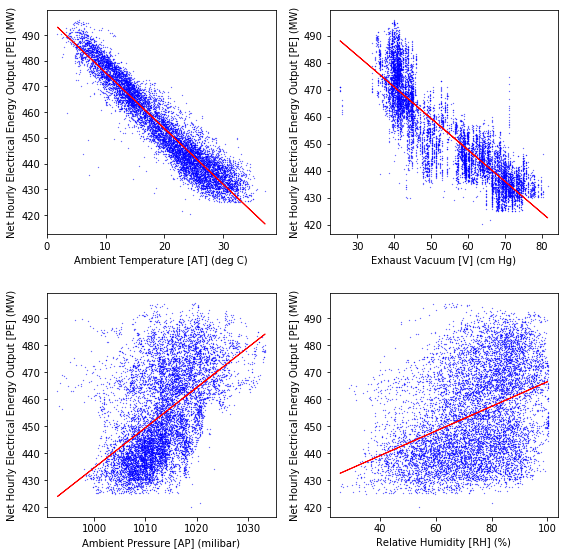

In [507]:
# 2 - c - Simple Linear Regression for each predicate

# Create linear regression object
regr = LinearRegression()
fig7 = plt.figure(7, figsize=(8,8))

y = np.array(pe_list)
for i in range(len(featurelist)):
    # subplot loc
    ax = fig7.add_subplot(2,2,i+1)
    
    # fit simple regression model
    print('Linear Regression for ' + rlabellist[i])
    x = np.reshape(datalist[i], (-1,1))
    regr.fit(x, y)
    statdata = getLinearRegStat(regr, x, y)
    uni_coef.append(statdata[0][1])
    
    # print summary table
    rowlabel = ['Intercept']
    rowlabel.append(coeflist[i])
    printStatSummary(clabellist, rowlabel, statdata)
    
    p = 2 * (1 - stats.t.cdf(np.abs(tval[1]), y.shape[0] - x.shape[1] - 1)) # deg of freedom n - 2
    
    # plot linear regression
    pred_y = regr.predict(x)
    ax.scatter(x, y,  s=0.5**2, c='b', marker='.')
    ax.plot(x, pred_y, color='red', linewidth=1)
    
    ax.set_xlabel(labellist[i])
    ax.set_ylabel('Net Hourly Electrical Energy Output [PE] (MW)')
    

fig7.tight_layout()
plt.show()

(2c)

When trying to fit a simple regression model for each predictor (independent variables), we can see that all the predictors (AT, V, AP, RH) are significant. The p-values are small, close to 0, indicating that predictors are statistically significant.

For AT and V, the linear regression model fits closely to the trend. However, for AP and RH predictors, even though the trend matches the linear model, it does not completely describe the data. These may be possible outliers which can be possibly removed to closely match the predicted model.

In [508]:
# 2 - d - Multiple Regression model
regr = LinearRegression()

# fit multiple regression model
new_x = np.array(featurelist).T # all features
regr.fit(new_x, y)
statdata = getLinearRegStat(regr, new_x, y)
multi_coef = statdata[0][1:]

# print summary table
rowlabel = ['Intercept'] + coeflist
printStatSummary(clabellist, rowlabel, statdata)

# f-stat test 
fval = statdata[4]
fcrit = stats.f.ppf(q=1-0.05, dfn=4, dfd=num_instances-4-1) # 95% confidence level
p_value = 1 - stats.f.cdf(fval, dfn=4, dfd=num_instances-4-1)
print('f-crit:', fcrit)
print("f-test-stat: {:.6f}".format(fval))
print('reject H0 with p-val:', p_value)


+-----------+-------------+------------+------------+---------+
|           | Coefficient | Std. Error |   t-stat   | p-value |
+-----------+-------------+------------+------------+---------+
| Intercept |  454.60927  |  9.74596   |  46.64593  | 0.00000 |
|     AT    |   -1.97751  |  0.01298   | -152.37767 | 0.00000 |
|     V     |   -0.23392  |  0.00559   | -41.86046  | 0.00000 |
|     AP    |   0.06208   |  0.00009   | 702.96122  | 0.00000 |
|     RH    |   -0.15805  |  0.00356   | -44.44048  | 0.00000 |
+-----------+-------------+------------+------------+---------+
f-crit: 2.372861060766642
f-test-stat: 31138.266764
reject H0 with p-val: 1.1102230246251565e-16


(2d)

From the results above, the p values for each of the predictors are small, meaning these features do have significance in determining the net electrical energy output. Therefore, we can reject the null hypothesis H0. Since F-test is greater than Fp,n-p-1 where p = 4 and n = num of instance, F-test is in the rejection region and can reject the claim that none of the independent variables affect the output Y. 

(2e)

Comparing the univariate vs multivariate results, according to the p-values, it seems that all the independent variables are all significant. 

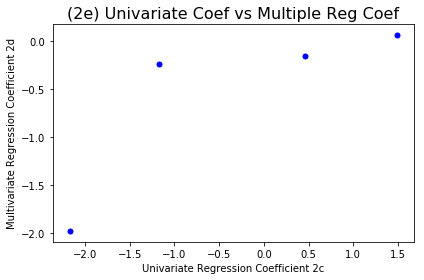

In [509]:
# 2 - e - Univariate Coef 2c vs Multivariate Ceof 2d

fig8 = plt.figure(8)
ax8 = fig8.add_subplot(1,1,1)
ax8.scatter(uni_coef, multi_coef,  s=10**2, c='b', marker='.')

plt.title('(2e) Univariate Coef vs Multiple Reg Coef', fontsize=16)
ax8.set_xlabel('Univariate Regression Coefficient 2c')
ax8.set_ylabel('Multivariate Regression Coefficient 2d')

fig8.tight_layout()
plt.show()

In [510]:
# 2 - f - Model each predictor X as Y = B0 + B1X + B2X^2 + B3X^3 + e (Finding Nonlinear association)
regr = LinearRegression()
blabellist = ['B0','B1', 'B2', 'B3']

y = np.array(pe_list)
for i in range(len(featurelist)):
    print('Non-Linear Regression for ' + coeflist[i])
    x = np.array(featurelist[i])
    new_x = np.array([x, x**2, x**3]).T
    
    # fit non-linear regression model
    regr.fit(new_x, y)
    statdata = getLinearRegStat(regr, new_x, y)
    
    # print summary table
    printStatSummary(clabellist, blabellist, statdata)
    
    fval = statdata[4]
    fcrit = stats.f.ppf(q=1-0.05, dfn=3, dfd=num_instances-3-1) # 95% confidence level
    p_value = 1 - stats.f.cdf(fval, dfn=3, dfd=num_instances-3-1)
    print('f-crit:', fcrit)
    print("f-test-stat: {:.6f}".format(fval))
    print('reject H0 with p-val:', p_value)
    print("\n")
    

Non-Linear Regression for AT
+----+-------------+------------+------------+---------+
|    | Coefficient | Std. Error |   t-stat   | p-value |
+----+-------------+------------+------------+---------+
| B0 |  492.72814  |  0.66310   | 743.07204  | 0.00000 |
| B1 |   -0.61035  |  0.04865   | -12.54651  | 0.00000 |
| B2 |   -0.12514  |  0.00086   | -145.34523 | 0.00000 |
| B3 |   0.00267   |  0.00000   | 599.16453  | 0.00000 |
+----+-------------+------------+------------+---------+
f-crit: 2.6058375524350423
f-test-stat: 32991.032417
reject H0 with p-val: 1.1102230246251565e-16


Non-Linear Regression for V
+----+-------------+------------+-----------+---------+
|    | Coefficient | Std. Error |   t-stat  | p-value |
+----+-------------+------------+-----------+---------+
| B0 |  554.14685  |  9.13496   |  60.66223 | 0.00000 |
| B1 |   -2.14438  |  0.06782   | -31.61785 | 0.00000 |
| B2 |   -0.00271  |  0.00022   | -12.60965 | 0.00000 |
| B3 |   0.00013   |  0.00000   | 327.90351 | 0.000

(2f)

Yes, for each of the predictors, there seems to be evidence that there is some nonlinear association. Based on the f-test statistics, we can reject the null hypothesis and conclude that there is at least one independent variable (x, x^2, x^3) that affects the output y.

In [511]:
# 2 - g - Interactions of predictor (pairwise interaction)
plabellist = ['Intercept', 'AT', 'V', 'AP', 'RH', 'ATxV', 'ATxAP', 'ATxRH', 'VxAP', 'VxRH', 'APxRH']
# Pairwise Terms = AT x V, AT x AP, AT x RH, V x AP, V x RH, AP x RH
np_feature = [np.array(feature) for feature in featurelist]

np_pairwise = []
for i in range(len(np_feature)):
    for j in np_feature[i+1:]:
        np_pairwise.append(np_feature[i]*j)
        
pairwise_x = np.array(np_feature + np_pairwise).T

# fit pair-wise linear regression model
regr = LinearRegression()
regr.fit(pairwise_x, y)
statdata = getLinearRegStat(regr, pairwise_x, y)

# print summary table
printStatSummary(clabellist, plabellist, statdata)
    

+-----------+-------------+------------+------------+---------+
|           | Coefficient | Std. Error |   t-stat   | p-value |
+-----------+-------------+------------+------------+---------+
| Intercept |  685.78247  |  78.58916  |  8.72617   | 0.00000 |
|     AT    |   -4.34701  |  2.12642   |  -2.04429  | 0.04095 |
|     V     |   -7.67486  |  0.89421   |  -8.58284  | 0.00000 |
|     AP    |   -0.15235  |  0.00165   | -92.30226  | 0.00000 |
|     RH    |   1.57091   |  0.27215   |  5.77230   | 0.00000 |
|    ATxV   |   0.02097   |  0.00058   |  35.95713  | 0.00000 |
|   ATxAP   |   0.00176   |  0.00002   |  94.37516  | 0.00000 |
|   ATxRH   |   -0.00523  |  0.00071   |  -7.32295  | 0.00000 |
|    VxAP   |   0.00681   |  0.00001   | 1060.67704 | 0.00000 |
|    VxRH   |   0.00084   |  0.00025   |  3.35216   | 0.00080 |
|   APxRH   |   -0.00161  |  0.00000   | -850.93833 | 0.00000 |
+-----------+-------------+------------+------------+---------+


(2g)

Yes, there is some association of interactions among the predictors. Given the p-values for each of the predictors and their interactive terms above, it seems that each term is significant and play an effect in the output.

In [512]:
# 2 - h
from sklearn.metrics import mean_squared_error

def splitDataset(dataset):
    np.random.shuffle(dataset) # shuffle data set

    training_size = int(num_instances * 0.7)
    training_data = dataset[:training_size+1]
    test_data = dataset[training_size+1:]
    
    assert(training_data.shape[0] + test_data.shape[0] == num_instances), "Error: splitting dataset!"

    # training/test data of all predictors
    x_training = training_data[:,:dataset.shape[1]-1] # getting all but the last col
    x_test = test_data[:,:dataset.shape[1]-1]

    y_training = training_data[:,dataset.shape[1]-1] # getting only the last col
    y_test = test_data[:,dataset.shape[1]-1]
    
    assert(x_training.shape[1] == x_test.shape[1] == (dataset.shape[1] - 1)), "Error: x col size"
    assert(y_training.shape[0] + y_test.shape[0] == dataset.shape[0]), "Error: y row size"
    
    return (x_training, y_training, x_test, y_test)

    
# select training/test data (randomly selected 70% of dataset of all predictors)
np_data = [np.array(feature) for feature in datalist]
dataset = np.array(np_data).T
x_training, y_training, x_test, y_test = splitDataset(dataset)

print("-- Linear Regression of all predictors --")
# fit linear regression with all predictors on training data
regr = LinearRegression()
regr.fit(x_training, y_training)

y_pred = regr.predict(x_training) # predict/test on test data
print("MSE training data: %.2f" % mean_squared_error(y_training, y_pred))

y_pred = regr.predict(x_test) # predict/test on test data
print("MSE of test data: %.2f" % mean_squared_error(y_test, y_pred))


print("-- Linear Regression of all predictors, interaction, nonlinear terms --")
# fit linear regression with interaction terms and quadratic nonlinearities
np_feature = [np.array(feature) for feature in featurelist]

# build all nonlinear terms
np_nonlinear_terms = []
for i in range(len(featurelist)):
    x = np_feature[i]
    np_nonlinear_terms.append(x**2)
    np_nonlinear_terms.append(x**3)

# build all pair-wise terms
np_pairwise_terms = []
for i in range(len(np_feature)):
    for j in np_feature[i+1:]:
        np_pairwise_terms.append(np_feature[i]*j)

np_new_data = np_feature + np_nonlinear_terms + np_pairwise_terms + [np.array(datalist[4])]
new_data = np.array(np_new_data).T

x_training, y_training, x_test, y_test = splitDataset(new_data)
regr = LinearRegression()
regr.fit(x_training, y_training)

y_pred = regr.predict(x_training) # predict/test on test data
print("MSE training data %.2f" % mean_squared_error(y_training, y_pred))

y_pred = regr.predict(x_test) # predict/test on test data
print("MSE of test data: %.2f" % mean_squared_error(y_test, y_pred))

-- Linear Regression of all predictors --
MSE training data: 21.22
MSE of test data: 19.72
-- Linear Regression of all predictors, interaction, nonlinear terms --
MSE training data 17.84
MSE of test data: 17.51


(2h)

Yes, there is an improvement in MSE using all predictors, interaction, and nonlinear terms than only considering the given predictors. Additionally, we can conclude that using all predictors, interaction, and nonlinear terms does not overfit the model because the MSE of both training data and test data are relatively similar.

In [513]:
# 2 - i - KNN Regression
from sklearn.neighbors import KNeighborsRegressor

k_list = np.arange(1,101,1)

x = np.array(featurelist).T # all features
y = np.array(pe_list)

dataset = np.array([np.array(feature) for feature in datalist]).T
x_training, y_training, x_test, y_test = splitDataset(dataset)

k_train_errmap = {}
k_train_msemap = {}

k_test_errmap = {} 
k_test_msemap = {}

for k in k_list:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(x_training, y_training)
    
    # record R^2 score for given K
    k_train_errmap[k] = neigh.score(x_training, y_training)
    k_test_errmap[k] = neigh.score(x_test, y_test)
    
    y_pred_train = neigh.predict(x_training)
    y_pred_test = neigh.predict(x_test)
    
    mse_train = mean_squared_error(y_training, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    # record MSE for given K
    k_train_msemap[k] = mse_train
    k_test_msemap[k] = mse_test


inv_k = [1/k for k in k_list]
train_err = [v for v in k_train_errmap.values()]
test_err = [v for v in k_test_errmap.values()]

train_mse = [v for v in k_train_msemap.values()]
test_mse = [v for v in k_test_msemap.values()]


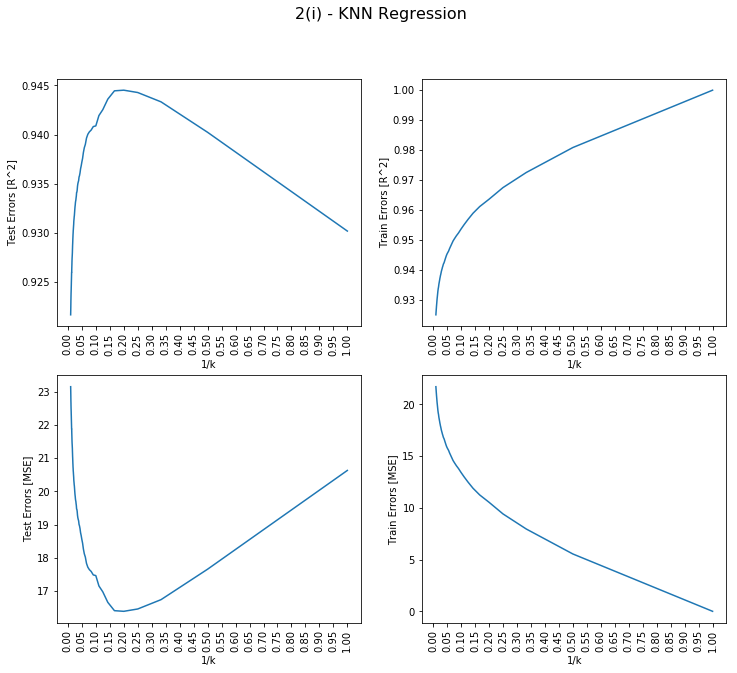

Best K value for Test Set: 5
Best K value for Training Set: 1
MSE (Test) for best-fit: 16.41520202187378
MSE (Train) for best-fit: 17.662692447735186


In [514]:
fig9 = plt.figure(9, figsize=(12,10))

x_list = [test_err, train_err, test_mse, train_mse]
x_label_list = ['Test Errors [R^2]', 'Train Errors [R^2]', 'Test Errors [MSE]', 'Train Errors [MSE]']
for i in range(len(x_list)):
    ax9_1 = fig9.add_subplot(2,2,i+1)
    ax9_1.plot(inv_k, x_list[i])
    ax9_1.set_xlabel('1/k')
    ax9_1.set_ylabel(x_label_list[i])
    ax9_1.set_xticks(np.arange(0, 1.05, 0.05)) # step size = 0.05
    minorLocator = MultipleLocator(0.1)
    ax9_1.xaxis.set_minor_locator(minorLocator) # show minor tick marks interval of 0.01
    plt.xticks(rotation='vertical')
    
fig9.suptitle('2(i) - KNN Regression', fontsize=16)
plt.show()

# finding the best k
max_test_err = 0
max_train_err = 0

test_kstar = 0
train_kstar = 0
for k in k_list:
    if k_test_errmap[k] > max_test_err:
        max_test_err = k_test_errmap[k]
        test_kstar = k
        
    if k_train_errmap[k] > max_train_err:
        max_train_err = k_train_errmap[k]
        train_kstar = k

print("Best K value for Test Set:", test_kstar)
print("Best K value for Training Set:", train_kstar)
print("MSE (Test) for best-fit:", test_mse[test_kstar])
print("MSE (Train) for best-fit:", test_mse[train_kstar])


(2j) KNN Regression vs Linear Regression

For KNN Regression, close the value of R^2, the better the test/training errors are. According to two plots above in section 2(i), we see that test errors improve as k becomes smaller, but after a certain point (k = 5), test errors decrease in improvement when k approaches 1. As for training error, we see that it improves as k approaches 1.

For Linear Regression, the MSE is usually better for training than the test dataset. Also, the test errors remain relatively similar to that of the training error. If the model had been an overfit, the test errors would have increased. 

The MSE for training dataset is 17.66 and 17.84 (see 2h), whereas the MSE for test dataset is 16.41 and 17.51 (see 2h) for KNN and Linear Regression, respectively. Comparing KNN and Linear Regression, the training MSE remains about the same, but we see an improvement in MSE for KNN regression. 

(3) ISLR 2.4.1

(a). flexible method better. Since large number of observations, it provides better, accurate estimated model and due to the small number of predictors, no need to be concerned with reducing the features to reduce complexity of model.

(b). flexible method worse. Having a large number of predictors and small observations results in more complex model because we are estimating based on more parameters. This could possibly result in overfitting and thus, losing generality.

(c). flexible method better. Since the relationship between the predictors and response is highly non-linear, we want more degree of freedom (increase the complexity of model) to represent the feature vector to closely model the non-linearity. 

(d). flexible method worse. Since there is high variance of error terms, if we increase flexibility, it leads to overfitting, meaning we are fitting the noise too closely. This results in increase of variability (more wiggly) in the estimated model, which may not be the case for the true model.

(4) ISLR 2.4.7

(a). Euclidean Distance Obs. to Test (0,0,0)

1. (0,3,0) to (0,0,0) = sqrt(0^2 + 3^2 + 0^2) = 3
2. (2,0,0) to (0,0,0) = sqrt(2^2 + 0^2 + 0^2) = 2
3. (0,1,3) to (0,0,0) = sqrt(0^2 + 1^2 + 3^2) = sqrt(10) = 3.16
4. (0,1,2) to (0,0,0) = sqrt(0^2 + 1^2 + 2^2) = sqrt(5) = 2.23
5. (-1,0,1) to (0,0,0) = sqrt((-1)^2 + 0^2 + 1^2) = sqrt(2) = 1.41
6. (1,1,1) to (0,0,0) = sqrt(1^2 + 1^2 + 1^2) = sqrt(3) = 1.73

(b). Prediction K = 1 of Test (0,0,0) = Green. Since we are looking at 1 closest neighbor using Euclidean metric, it is Obs. 5 which is the closest to the Test point.

(c). Prediction K = 3 of Test (0,0,0) = Red. We are looking at 3 closest neighbors which are Obs. 5, 6, 2 and 2 out 3 of them Red, so Test is determined to be Red by majority polling.

(d). If the decision boundary is non-linear, we want K to be small. As K increase, the decision boundary becomes more linear and inflexible because we are considering more data points to determine the boundary.
